# Abstract

This is just the [Celeb-Faces](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) VAE example. Based on the [Github Repository associated with the book _Generative Deep Learning: Teaching Machines to paint, write, compose and play_](https://github.com/davidADSP/GDL_code)

It builds on digits by

1. Having more 


Not yet finished is

What is `GradientTape` and when would you use it

# Prelude

## Imports

In [1]:
from typing import NamedTuple, List, Union, Tuple, Optional

import numpy as np
import sys
import math
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, Conv2DTranspose, \
  Activation, LeakyReLU, Dropout, BatchNormalization, Reshape, Lambda

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K  # tensor operations

In [2]:
import logging

## Configuration

In [3]:
RUNNING_ON_COLAB = False
try:
    from google.colab import drive
    RUNNING_ON_COLAB = TRUE
except:
    logging.info("Running locally. Not running on Google Colab")

In [4]:
CHECKPOINT_DIR = pathlib.Path.cwd()  / 'checkpoints' / 'celeb_faces'

if not CHECKPOINT_DIR.exists():
  CHECKPOINT_DIR.mkdir(parents=True)

In [5]:
if RUNNING_ON_COLAB:
    GDRIVE_DIR_BASE = pathlib.Path('/') / 'content' / 'drive'
    MY_GDRIVE_DIR = GDRIVE_DIR_BASE / 'MyDrive'
else:
    # Assume we're running my laptop in Windows
    MY_GDRIVE_DIR = pathlib.Path.home() / 'Google Drive'
    if not MY_GDRIVE_DIR.exists():
        # Assume we're running my laptop in Linux, with GDrive on the Windows partition
        ROOT_DIR = pathlib.Path(pathlib.Path.home().root)
        WIN_DRIVE = ROOT_DIR / 'media' / pathlib.Path.home().name / 'Blade 15'
        WIN_HOME = WIN_DRIVE / 'Users' / pathlib.Path.home().name
        if not WIN_HOME.exists():
            import os
            import pwd
            first_name = pwd.getpwuid(os.getuid())[4].lower().split(' ')[0]
            WIN_HOME = WIN_DRIVE / 'Users' / first_name

        MY_GDRIVE_DIR = WIN_HOME / 'Google Drive'
        
COLAB_DATA_DIR = MY_GDRIVE_DIR / 'Colab Data'
DATA_ZIP_FILE = COLAB_DATA_DIR / 'img_align_celeba.zip' 
DATA_DIR = COLAB_DATA_DIR / 'img_align_celeba'
DATA_CLASS_DIR = DATA_DIR / 'all_images'

In [6]:
logging.basicConfig()
level = logging.INFO
logger = logging.getLogger()
logger.setLevel(level)
for handler in logger.handlers:
    handler.setLevel(level)

In [7]:
# Tensorflow v2.4 on CUDA 11

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)  

# Can also write
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Prep and Quantification

In [8]:
if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.mount(str(GDRIVE_DIR_BASE))

In [10]:
if not DATA_DIR.exists():
  logging.info(f"Unpacking Celeb Face dataset from {DATA_ZIP_FILE} to {DATA_DIR}")
  DATA_DIR.mkdir()
  DATA_CLASS_DIR.mkdir()

  import zipfile
  with zipfile.ZipFile(DATA_ZIP_FILE, 'r') as zip_ref:
    BATCH_SIZE = 5000
    pics = zip_ref.namelist()
    pics_batches = [pics[s:s+BATCH_SIZE] for s in range(0, len(pics), BATCH_SIZE)]

    for batch_id, pics_batch in enumerate(pics_batches):
      last_file = DATA_DIR / last_file
      logging.info(f"Checking for existance of file {last_file}")
      if not last_file.exists():
        logging.info(f"Extracting batch {batch_id} of {len(pics_batches)}")
        zip_ref.extractall(DATA_CLASS_DIR, members=pics_batch)

# VAE Code

This code is identical to that used for the digits example with the exceptions of parameter values and

 1. Removal of some comments from the `_make_vae_encoder()` function.
 2. Use Keras `ImageDataGenerator` to load images into memory on demand, instead of doing it all in memory


 ##  Building the Network

In [11]:
class CLayerGroup(NamedTuple):
  filter_count: int = 32
  kernel_size: int = 3
  stride_size: int = 1
  padding: str = 'same'

  activation: str = 'leakyrelu'
  batch_norm_enabled: bool = False 
  dropout: Optional[float] = None


  def make_layer(self, name: Optional[str] = None) -> Conv2D:
    return Conv2D(
        filters=self.filter_count,
        kernel_size = (self.kernel_size, self.kernel_size),
        strides=self.stride_size,
        padding=self.padding,
        name=name
    )

  def make_activation(self, name: Optional[str] = None) -> Union[LeakyReLU, Activation]:
    if self.activation == 'leakyrelu':
      return LeakyReLU(name=name)
    else:
      return Activation(self.activation, name=name)

  def make_transpose_layer(self, name:str = None) -> Conv2D:
    return Conv2DTranspose(
        filters=self.filter_count,
        kernel_size = (self.kernel_size, self.kernel_size),
        strides=self.stride_size,
        padding=self.padding,
        name=name
    )

In [12]:
def _tidy_name_prefix(name_prefix: Optional[str]) -> str:
  """
  Converts None to the empty string, and strips leading/trailing
  whitespace. If the the name-prefix is not none/the empty string,
  ensure that it ends in an underscore by adding one if missing.
  """
  if name_prefix is None:
    return ''
  name_prefix = name_prefix.strip()
  if len(name_prefix) == 0:
    return ''
  if name_prefix[-1] == '_':
    return name_prefix
  else:
    return name_prefix + '_'

In [13]:
def _make_vae_encoder(input_tensor: Input, 
                      encoders: List[CLayerGroup],
                      z_dim: int,
                      name_prefix: str) -> Tuple[Model, 
                                                 Tuple["KerasTensor", "KerasTensor"], 
                                                 Tuple[int, ...]]:
  """
  Creates an encoder according to the given specification. Returns the 
  encoder model, the (placeholder) tensor representing the output of the
  encoder, and the shape immediately before flattenng and projecting

  Exactly the same as _make_encoder except we also predict the log-variance
  (log to enforce positivity constraint), and then add scaled-Gaussian noise
  to the prediction...
  """
  _p = name_prefix

  x = input_tensor
  for e_idx, encoder in enumerate(encoders):
    conv_layer = encoder.make_layer(f'{_p}venc_conv_{e_idx}')
    x = conv_layer(x)
    
    if encoder.batch_norm_enabled:
      x = BatchNormalization(name=f'{_p}venc_bnorm_{e_idx}')(x)
    
    act = encoder.make_activation(name=f'{_p}venc_act_{e_idx}')
    x = act(x)

    if encoder.dropout is not None:
      x = Dropout(rate=encoder.dropout, name=f'{_p}venc_dropout_{e_idx}')(x)

  shape_before_flatten = K.int_shape(x)[1:]  # First dimension is dataset size
  x = Flatten(name=f'{_p}venc_flatten')(x)

  param_mean = Dense(units=z_dim, name=f'{_p}venc_output_mean')(x)
  param_log_var = Dense(units=z_dim, 
                        activation='tanh',  # Needed for when we don't have KL regularization
                        name=f'{_p}venc_output_log_var')(x)
  
  encoder_parameter_model = Model(input_tensor, (param_mean, param_log_var))

  def sample_from_encoded_space(args: Tuple["KerasTensor", ...]) -> "KerasTensor":
    m, l = args
    scale = K.random_normal(shape=K.shape(m), mean=0.0, stddev=1.0)
    sample = m + K.exp(l / 2) * scale
    return sample

  encoder_output_tensor = Lambda(
      function=sample_from_encoded_space,
      name=f'{_p}venc_sample'
  )([param_mean, param_log_var])

  # encoder_model = Model(input_tensor, encoder_output_tensor)
  encoder_model = Model(input_tensor, encoder_output_tensor)

  # return encoder_model, encoder_output_tensor, shape_before_flatten, (param_mean, param_log_var)
  return encoder_model, encoder_output_tensor, shape_before_flatten, (param_mean, param_log_var)

In [14]:
def _make_decoder(input_tensor: Input,
                  decoders: List[CLayerGroup],
                  unflatten_shape: Tuple[int, ...],
                  name_prefix: str) -> Model:
  _p = name_prefix

  # Explode from z_dim to original shape at end of convolutional chain
  x = Dense(units=np.prod(unflatten_shape), name=f'{_p}dec_expand')(input_tensor)
  x = Reshape(unflatten_shape, name=f'{_p}dec_unflat')(x)  # Note how this skips first dimension: dataset-size

  # Apply all but the last decoders (see below)
  for d_idx, decoder in enumerate(decoders[:-1]):
    conv_t_layer = decoder.make_transpose_layer(f'{_p}dec_conv_{d_idx}')
    x = conv_t_layer(x)

    if decoder.batch_norm_enabled:
      x = BatchNormalization(name=f'{_p}dec_bnorm_{d_idx}')(x)

    act = decoder.make_activation(name=f'{_p}dec_act_{d_idx}')
    x = act(x)

    if decoder.dropout is not None:
      x = Dropout(rate=decoder.dropout, name=f'{_p}dec_dropout_{d_idx}')(x)

  # The last decoder gets special attention as it should produce exactly the
  # input, so we have to use sigmoid, and can't dropout
  decoder = decoders[-1]
  assert decoder.dropout is None, "Final decoder can't have dropout"
  assert not decoder.batch_norm_enabled, "Final decoder can't have batch norm enabled"
  assert decoder.activation == 'sigmoid', "Final decoder can only use sigmoid activation"

  conv_t_layer = decoder.make_transpose_layer(f'{_p}dec_final_decode')
  x = conv_t_layer(x)

  act = Activation('sigmoid', name=f'{_p}dec_sigmoid_output')
  output_tensor = act(x)

  return Model(input_tensor, output_tensor)

In [15]:
def make_vae_autoencoder(input_shape: Tuple[int, ...], 
                         encoders: List[CLayerGroup], 
                         decoders: List[CLayerGroup],
                         z_dim: int,
                         z_var_prior: float = 1,
                         likely_var = 1,
                         name_prefix: Optional[str] = None) -> Model:
  log_z_var_prior = math.log(z_var_prior)
  name_prefix = _tidy_name_prefix(name_prefix)

  enc_input_tensor = Input(shape=input_shape, name=f'{name_prefix}encoder_input')
  encoder, enc_output_tensor, projected_shape, (mu, log_var) = \
    _make_vae_encoder(enc_input_tensor, encoders, z_dim, name_prefix)

  dec_input_tensor = Input(shape=(z_dim,), name=f'{name_prefix}decoder_input')
  decoder = _make_decoder(dec_input_tensor, decoders, projected_shape, name_prefix)

  dec_output_tensor = decoder(enc_output_tensor) # Applying a model to a placeholder
                                                 # tensor to get an output tensor.
  vae = Model(enc_input_tensor, dec_output_tensor)

  # Regularization loss is best handled via add_loss functions. These will be
  # added to the overall loss in training...
  kl_loss = (1/likely_var) * -0.5 * tf.reduce_mean(log_var - log_z_var_prior  - K.square(mu/z_var_prior) - K.exp(log_var)/z_var_prior + 1)
  vae.add_loss(kl_loss)

  return vae, encoder, decoder, mu, log_var

## Monitoring the Network Training

In [16]:
# A callback to regulate convergence

from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint

def step_decay_schedule(initial_learning_rate: float,
                        decay_factor: float = 0.5,
                        step_size: int = 1) -> LearningRateScheduler:
  """
  Create a learning-rate schedule that amends the learning-rate
  every step_size epochs.

  t = epoch // step_size
  lr[epoch] = lr[epoch-1] * decay^t 

  """
  def learning_rate_at_epoch(epoch: int) -> float:
    new_lr = initial_learning_rate * (decay_Factor ** (epoch // step_size))

  return LearningRateScheduler(schedule=learning_rate_at_epoch)

In [17]:
initial_learning_rate = 0.0005
decay_factor = 1
step_size = 1

learning_rate_callback = LearningRateScheduler(
    schedule=lambda epoch: initial_learning_rate * (decay_factor **  (epoch // step_size))
)

ae_checkpoint_file = CHECKPOINT_DIR / 'simple-ae'
weight_save_check_point_callback = ModelCheckpoint(filepath=ae_checkpoint_file,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=1)

In [18]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Experiments

Building and Training a Network

In [19]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32
SCALE_FACTOR = 1./255


In [20]:
list(DATA_DIR.iterdir())

[PosixPath('/media/bfeeney/Blade 15/Users/bryan/Google Drive/Colab Data/img_align_celeba/all_images'),
 PosixPath('/media/bfeeney/Blade 15/Users/bryan/Google Drive/Colab Data/img_align_celeba/Anno')]

In [21]:
data_gen = ImageDataGenerator(rescale=SCALE_FACTOR,
                              validation_split=0.25)

# Note that data-flow is highly coupled with training strategy including
#  - batch-size
#  - error function (via class-mode)
#  - input dimension
data_flow_train = data_gen.flow_from_directory(
  directory=DATA_DIR,
  target_size=INPUT_DIM[:2],
  batch_size=BATCH_SIZE,
  shuffle=True,
  class_mode='input',  # class-label is same as input, i.e. autoencoding
  subset='training'
)

data_flow_valid = data_gen.flow_from_directory(
  directory=DATA_DIR,
  target_size=INPUT_DIM[:2],
  batch_size=BATCH_SIZE,
  shuffle=True,
  class_mode='input',  # class-label is same as input, i.e. autoencoding
  subset='validation'
)

Found 78336 images belonging to 2 classes.
Found 26112 images belonging to 2 classes.


In [22]:
NUM_IMAGES=len(data_flow_train.filepaths)

In [23]:
import PIL

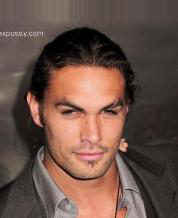

In [24]:
pic_0 = PIL.Image.open(data_flow_train.filepaths[0])
pic_0

In [25]:
import tensorflow.keras.backend as kbackend
kbackend.clear_session()

encoder_layers = [
    CLayerGroup(filter_count=32, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25)
]

decoder_layers = [
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=64, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=32, kernel_size=3, stride_size=2, batch_norm_enabled=True, dropout=0.25),
    CLayerGroup(filter_count=3, kernel_size=3, stride_size=2, 
                batch_norm_enabled=False, dropout=None, activation='sigmoid')
]

vae, venc, dec, mu, log_var = make_vae_autoencoder(input_shape=INPUT_DIM,
                                                   encoders=encoder_layers,
                                                   decoders=decoder_layers,
                                                   z_dim=200,
                                                   z_var_prior=4,
                                                   likely_var=4,
                                                   name_prefix='vae')

In [26]:
from tensorflow.keras.losses import MeanSquaredError

EPOCHS=5
STEPS_PER_EPOCH = NUM_IMAGES // BATCH_SIZE  # Note tie to DataFlow

loss_fn = MeanSquaredError()
opt = Adam(learning_rate=0.0005)

vae.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=['mse', 'accuracy']
)

{'epochs': EPOCHS, 'steps_per_epoch': STEPS_PER_EPOCH, 'num_images': NUM_IMAGES, 'batch_size': BATCH_SIZE}

{'epochs': 5, 'steps_per_epoch': 2448, 'num_images': 78336, 'batch_size': 32}

In [27]:
vae.fit(data_flow_train,
        validation_data=data_flow_valid,
        shuffle=True,
        initial_epoch=0,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
                  learning_rate_callback,
                  weight_save_check_point_callback
       ]
)

Epoch 1/5
2448/2448 [==============================] - 160s 64ms/step - loss: 0.0592 - mse: 0.0421 - accuracy: 0.6838 - val_loss: 0.0446 - val_mse: 0.0282 - val_accuracy: 0.7627

Epoch 00001: val_accuracy improved from -inf to 0.76265, saving model to /home/bfeeney/Documents/GitHub/gdnn-experiments/checkpoints/celeb_faces/simple-ae
Epoch 2/5
2448/2448 [==============================] - 135s 55ms/step - loss: 0.0459 - mse: 0.0297 - accuracy: 0.7580 - val_loss: 0.0433 - val_mse: 0.0266 - val_accuracy: 0.7694

Epoch 00002: val_accuracy improved from 0.76265 to 0.76941, saving model to /home/bfeeney/Documents/GitHub/gdnn-experiments/checkpoints/celeb_faces/simple-ae
Epoch 3/5
2448/2448 [==============================] - 140s 57ms/step - loss: 0.0446 - mse: 0.0284 - accuracy: 0.7597 - val_loss: 0.0428 - val_mse: 0.0259 - val_accuracy: 0.7670

Epoch 00003: val_accuracy did not improve from 0.76941
Epoch 4/5
2448/2448 [==============================] - 146s 59ms/step - loss: 0.0441 - mse: 0.0

In [28]:
vae.load_weights(CHECKPOINT_DIR / 'simple-ae')

# VAE Use-Cases with Faces Data

## Denoising Images

Can we make a prediction of a true face given a sample face?

In [29]:
import matplotlib.pyplot as plt

In [30]:
BATCH_SIZE

32

In [31]:
q, _ = next(data_flow_valid)  # the second entry is the "output", which for this is the 
                              # same as the input. 

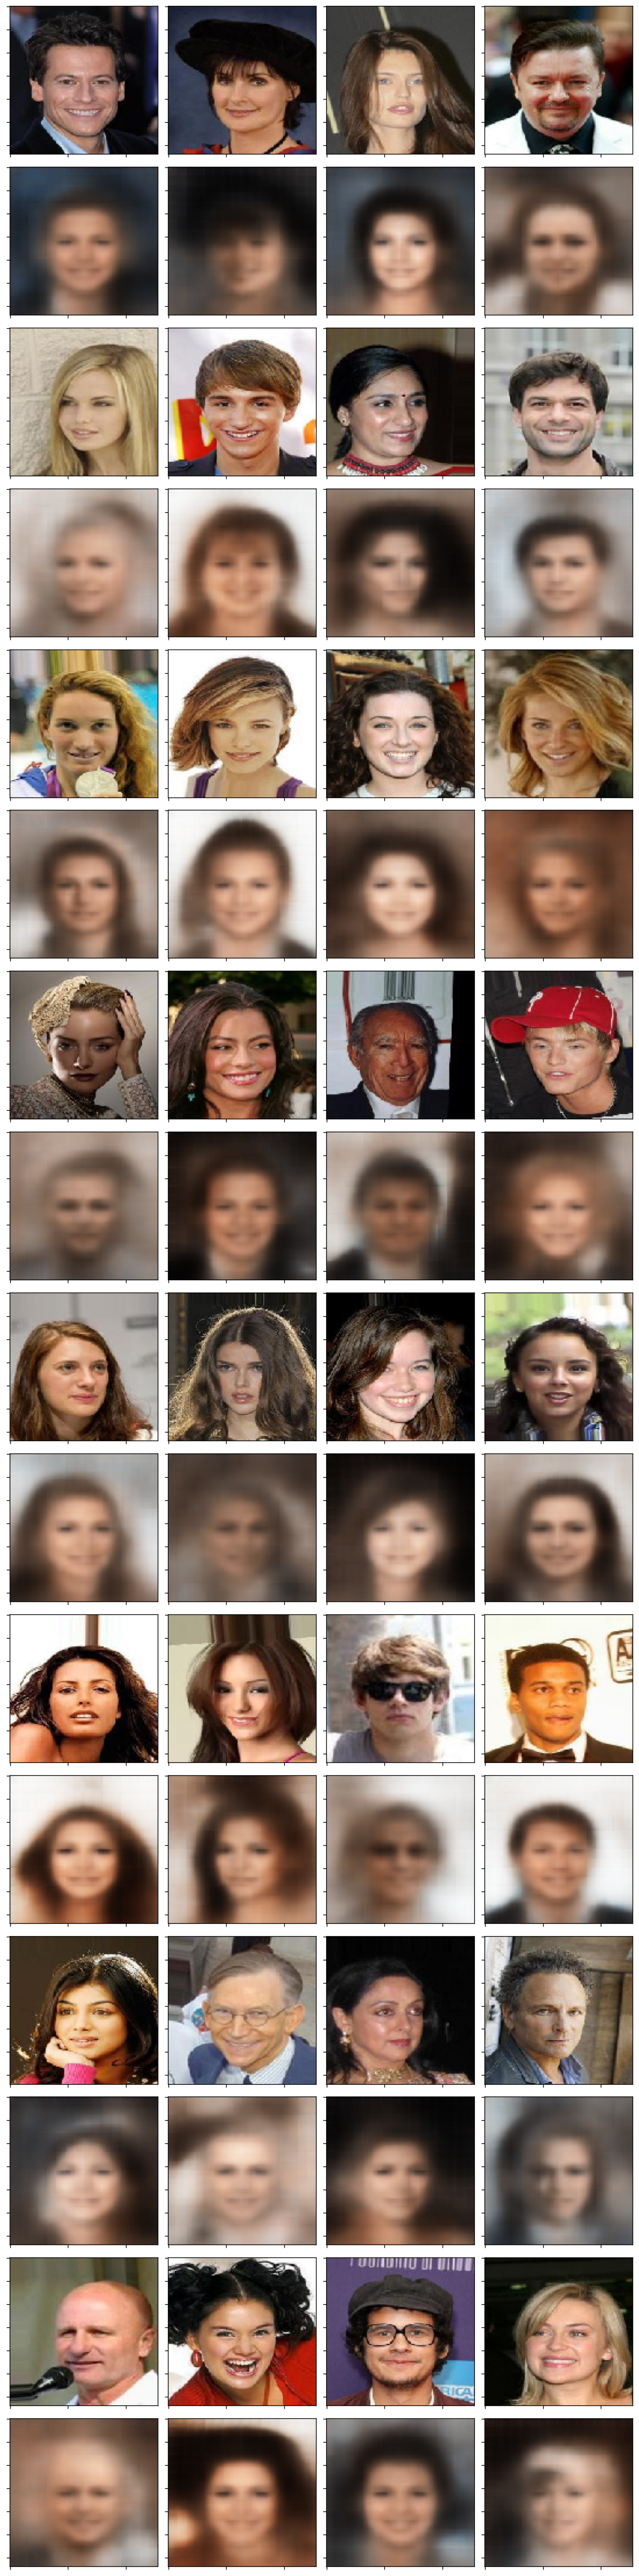

In [32]:
p = vae.predict(q)

ncols = 4
nrows = int(math.ceil(BATCH_SIZE / ncols))
nrows *= 2

imsize = 2.5
fig, axes = plt.subplots(figsize=(imsize * ncols, imsize * nrows), dpi=120,
                         nrows=nrows, ncols=ncols)
for i in range(BATCH_SIZE):
    orig = q[i]
    denoised = p[i]
    
    col = i % ncols
    row = (i // ncols) * 2
    
    axes[row + 0, col].imshow(orig)
    axes[row + 1, col].imshow(denoised)
    
    axes[row + 0, col].set_xticklabels([])
    axes[row + 1, col].set_xticklabels([])
    axes[row + 0, col].set_yticklabels([])
    axes[row + 1, col].set_yticklabels([])
    
fig.tight_layout()

## Latent Space

In [33]:
z = venc.predict(q)

<AxesSubplot:>

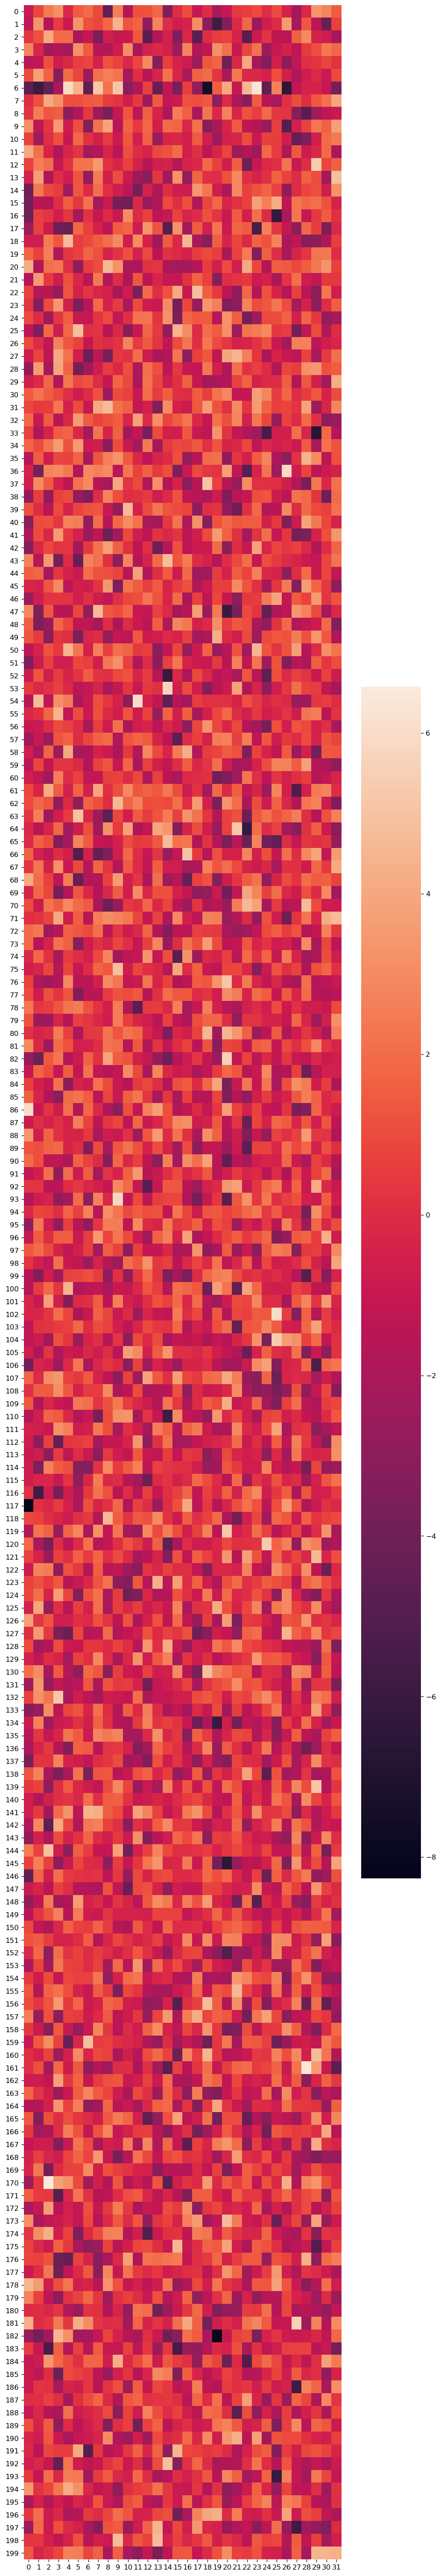

In [34]:
fig, ax = plt.subplots(figsize=(32//3, 200//3), dpi=120)
sns.heatmap(z.T, ax=ax)

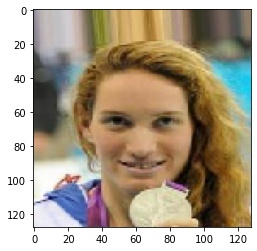

In [35]:
plt.imshow(q[8])

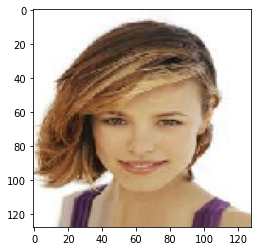

In [36]:
plt.imshow(q[9])

## Random Faces

In [37]:
import numpy.random as rd
rd.seed(0xC0FFEE)

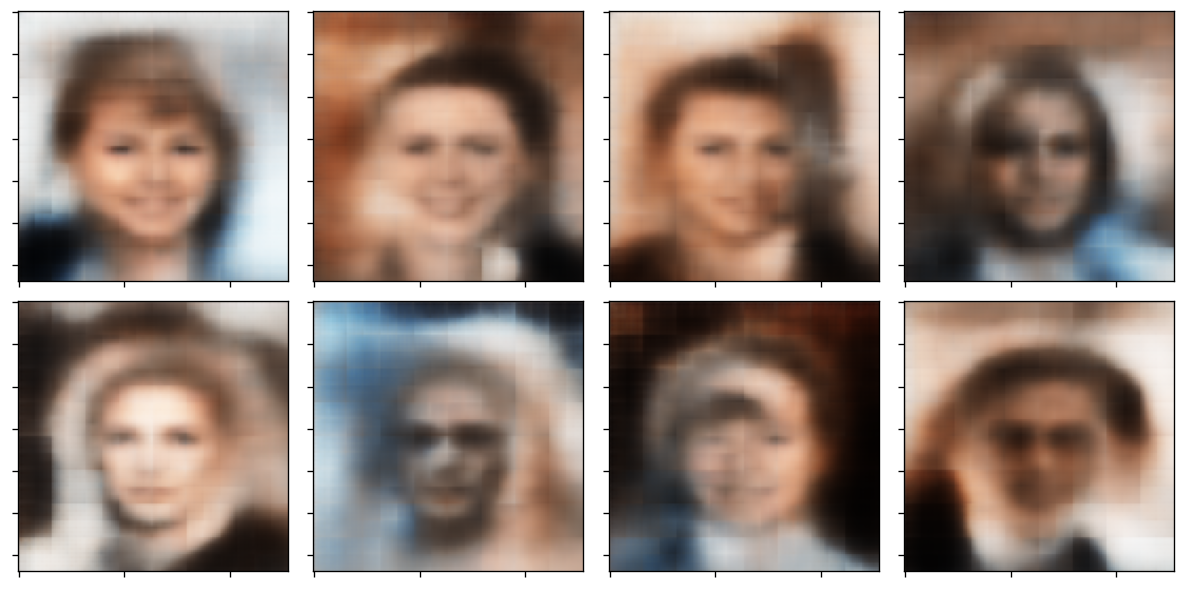

In [38]:
ztest = rd.normal(loc=0, scale=4, size=(8, 200))
p = dec.predict(ztest)

ncols = 4
nrows = int(math.ceil(p.shape[0] / ncols))

imsize = 2.5
fig, axes = plt.subplots(figsize=(imsize * ncols, imsize * nrows), dpi=120,
                         nrows=nrows, ncols=ncols)
for i in range(p.shape[0]):
    col = i % ncols
    row = (i // ncols)
    
    axes[row, col].imshow(p[i])
    
    axes[row, col].set_xticklabels([])
    axes[row, col].set_yticklabels([])
    
fig.tight_layout()

In [39]:
zmean = z.mean(axis=0)
zstd = z.std(axis=0)

zmean.mean(), zstd.mean()

(0.017296992, 1.8371875)

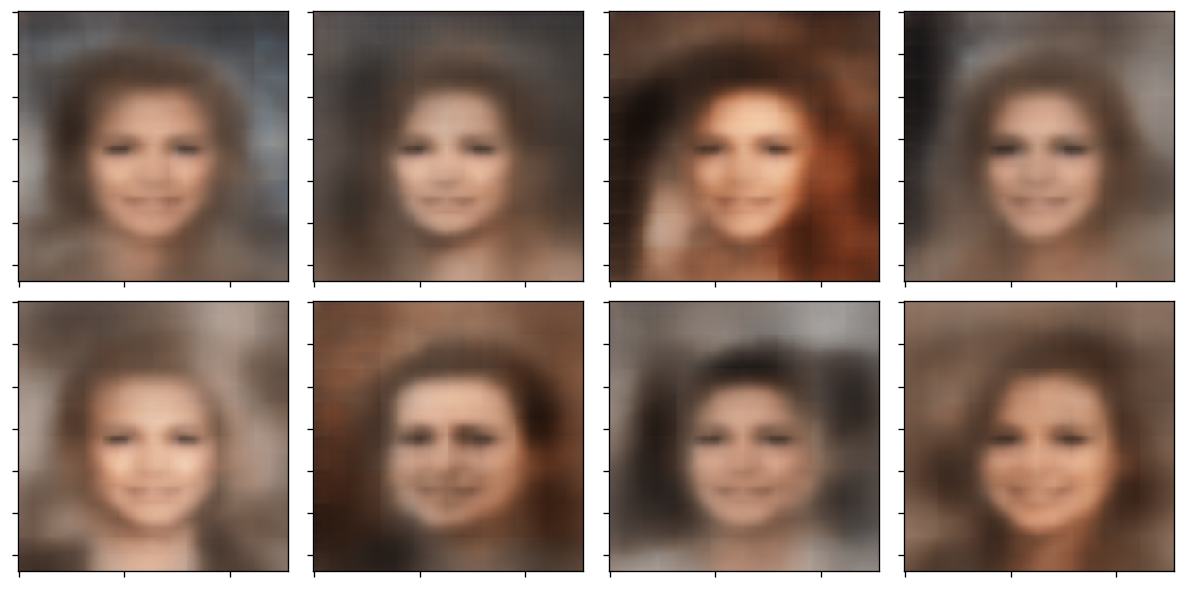

In [40]:
ztest = rd.normal(loc=zmean, scale=zstd, size=(8, 200))
p = dec.predict(ztest)

ncols = 4
nrows = int(math.ceil(p.shape[0] / ncols))

imsize = 2.5
fig, axes = plt.subplots(figsize=(imsize * ncols, imsize * nrows), dpi=120,
                         nrows=nrows, ncols=ncols)
for i in range(p.shape[0]):
    col = i % ncols
    row = (i // ncols)
    
    axes[row, col].imshow(p[i])
    
    axes[row, col].set_xticklabels([])
    axes[row, col].set_yticklabels([])
    
fig.tight_layout()

## Match Latent Dimensions to Labelled Attributes

In [41]:
import pandas as pd

ATTR_FILE = DATA_DIR / 'Anno' / 'list_attr_celeba.txt'
attrs = pd.read_csv(ATTR_FILE, skiprows=1, delim_whitespace=True)
attrs = np.maximum(attrs, 0).astype(bool).reset_index()
# attrs['index'] = attrs['index'].apply(lambda s: str(DATA_CLASS_DIR / s))

In [42]:
with pd.option_context("display.max_columns", 1000):
    display(attrs.head(3))

index  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg             False             True        True            False   
1  000002.jpg             False            False       False             True   
2  000003.jpg             False            False       False            False   

    Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  Blurry  \
0  False  False     False     False       False       False   False   
1  False  False     False      True       False       False   False   
2  False  False      True     False       False       False    True   

   Brown_Hair  Bushy_Eyebrows  Chubby  Double_Chin  Eyeglasses  Goatee  \
0        True           False   False        False       False   False   
1        True           False   False        False       False   False   
2       False           False   False        False       False   False   

   Gray_Hair  Heavy_Makeup  High_Cheekbones   Male  Mouth_Slightly_Open  \
0      False          True             True  False                 True   
1      False         False             True  False                 True   
2      False         False            False   True                False   

   Mustache  Narrow_Eyes  No_Beard  Oval_Face  Pale_Skin  Pointy_Nose  \
0     False        False      True      False      False         True   
1     False        False      True      False      False        False   
2     False         True      True      False      False         True   

   Receding_Hairline  Rosy_Cheeks  Sideburns  Smiling  Straight_Hair  \
0              False        False      False     True           True   
1              False        False      False     True          False   
2              False        False      False    False          False   

   Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0      False              True        False              True   
1      False             False        False             False   
2       True             False        False             False   

   Wearing_Necklace  Wearing_Necktie  Young  
0             False            False   True  
1             False            False   True  
2             False            False   True

In [43]:
attrs = attrs.set_index(['index']).stack(level=-1).to_frame().rename(columns={0:'label'})

In [44]:
attrs.reset_index()

index           level_1  label
0        000001.jpg  5_o_Clock_Shadow  False
1        000001.jpg   Arched_Eyebrows   True
2        000001.jpg        Attractive   True
3        000001.jpg   Bags_Under_Eyes  False
4        000001.jpg              Bald  False
...             ...               ...    ...
8103955  202599.jpg       Wearing_Hat  False
8103956  202599.jpg  Wearing_Lipstick   True
8103957  202599.jpg  Wearing_Necklace  False
8103958  202599.jpg   Wearing_Necktie  False
8103959  202599.jpg             Young   True

[8103960 rows x 3 columns]

In [45]:
df_flow = data_gen.flow_from_dataframe(
    attrs,
    directory=DATA_CLASS_DIR,
    x_col='index',
    y_col=[c for c in attrs if c != 'index'],
    class_mode='multi_output',
    target_size=INPUT_DIM[:-1]
)

KeyError: 'index'

In [ ]:
q,l = next(df_flow)

In [ ]:
l

In [ ]:
attrs

# Conclusions

We've created two VAEs. 

We've observed the (surprisingly large) amount of observation noise (variance in the likelihood) you need to add for the model to fit anything useful, the regularization is very weak indeed.

We've found out about ImageDataGenerator and how it can be used both to augment data via various transforms, and provide a way of feeding in data from disk instead of loading everything into a numpy array.

We've not had to change much of the VAE compared to the digit example. 

We've also seen just how many tunable parmeters there are, and how long it can take to train something.

We've seen the importance of callbacks to save the state as we go -- we've forgotten to use them in the example above.

We do need to write a little more about all these APIs.

Finally, we've updated our knowledge about Keras and how to use regularization.

The last thing to note about this is the metrics seems all screwy. It's easy to improve accuracy and get a prediction that's just a load of mush. There's a terrifying amount of luck in all this.

It seems like you generally want your learning rate to be <= 0.0009